<a href="https://colab.research.google.com/github/LimJongYoon/2020MLP/blob/master/%EC%A4%91%EA%B0%84%EA%B3%A0%EC%82%AC_lesson1_pets%20%EB%8B%B5%EB%B3%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

[87\100]

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

# Question 1: from fastai.vision import * 문장은 fastai.vision 모듈에 정의되어 있는 모든 클래스와 함수 와 상수들을 
# 임포트하는 것이다. 


##(1.1) 이렇게 임포트한 것들 (이름들, names) 을 모두 나열하라.
##[A] models, __init__, cyclegan, data, gan, image, 
##    interpret, learner, trensform, tta

##(1.2) 그 중에서 본 노트북에서 실제로 사용하는 것이 무엇인지 기술하라.
##[A] __init__,,models, learner, interpret



# fastai.vision 모듈은 왼쪽 칼럼에서 네모 아이콘을 클릭하면 개인 사용자의 폴더 구조가 나오는데 여기서 
# /usr/local/lib/python3.6/dist-packages/fastai 폴더 내부에 있고, 
# fastai 내부에서 언급하는 다른 패키지들도 다 dist-packages 안에 존재한다.  
# Import 명령의 작동원리에 대해서는 여기 참조: https://docs.python.org/3/tutorial/modules.html#importing-from-a-package


Question 1 [5\10]

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [ ]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
# Question 2: bs 값은 아래에 나오는 명령어 ImageDataBunch.from_name_re() 의 인풋 파라미터 중의 하나이다.


##(2.1) 이 파라미터의 역할이 무엇인지 설명하라. 
##[A] batch size로 한번에  train 시킬 양을 말한다.
##    예를들어 1000개의 데이터가 있을때  BS를 10으로 정한다면 
##    1epoch에 100번의 스텝을 진행하게 된다는 뜻이다.


##(2.2) 이 값을 증가시킬 때 어떤 일이 일어날 수 있는지 그리고 이 값을 감소 시킬 때 어떤 일이 일어날 수 있는지 설명하라.  
##[A] BS가 커지면 한번에 많은 량을 학습하기 때문에 Train 속도가 빨라진다. 
##    그러나 GPU의 할당량이 많이 필요하므로 자신의 컴퓨터 사양에 맞는 적절한 값을 찾아야한다.
##    또 BS가 작아지면 GPU메모리를 적게 차지한다는 장점이 있으나, Train 속도가 느려지게 된다.

Question 2 [9\10]

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [ ]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [ ]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [ ]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [ ]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_44.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_81.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_26.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_175.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_49.jpg')]

In [ ]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)
# Question 3: ImageDataBunch.from_name_re() 메소드는 파일 path 로부터 특정 조건을 만족하는 파일들을 찾아서 이를 data 
# 에 집어넣는 일을 한다. 이 data 는 신경망 학습에 사용될 것이므로, 이를 잘 준비하는 것은 매우 중요한 일이다. 
# 위 문장은 data = ImageDataBunch.methodA().methodB() 의 모양을 가지고 있다. 이것은 ImageDataBunch.methodA()  에 생성된 
# object 에 methodB() 를 적용하여 object 를 생성하고 이것을 data 에 할당하라는 뜻이다.


##(3.1)  methodA가 하는 일을 상세하기 기술하라.
##[A] Databunch 객체를 반환합니다. fastai에서 모델링하는 모든 것은 DataBunch의 객체가 되는데,
##    기본적으로 DataBunch 객체에는 2개 또는 3개의 데이터 세트가 포함됩니다. 여기에는 학습데이터, 
##    검증 데이터 및 선택적인 테스트트 데이터도 포함됩니다.
##    이것들은 각각 이미지와 레이블, 텍스트와 레이블 또는 표 형식 데이터와 레이블 등이 포함됩니다. 
##    이런 파일(data)들을 불러와서 우리 사용하기위한 data에 집어넣습니다. 


# methodA는 많은 인풋 파라미터를 가지고 있는데, 이를 고려하여 하는 일을 기술하라. docs.fast.ai 를 참고하라. 


##(3.2) 그리고 methodB (normalize) 가 하는 일도 기술하라. 특히 이 메소드의 인풋 파라미터인 imagenet_stats 를 언급하면서 하는 일을 기술하라.                                  
##[A] 머신러닝은 모든데이터를 동일한 크기로 만들어 줘야하는데(동일한 평균(0) 및 표준편차(1)) 
##    이 정규화 작업을 한다.
##    여기에서 imagenet_stats 파라미터를 사용하는 이유는 
##    직접 train 하지 않고 사전 훈련 모델을 사용하는 경우이기 때문이다.
##    이미 train된 데이터를 사용할 때는 원본 imagenet 데이터의 평균 및 표준편차를 사용해야 하는데
##    이는 imagenet_stats에 저장되있다.

Question 3 [8\10]

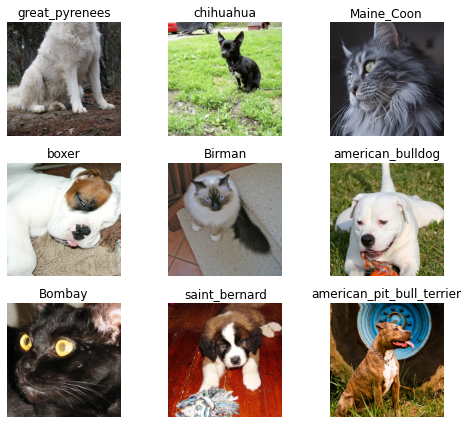

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# Question 4: cnn_learner() 는 함수이다. 파이선에서 함수라는 말은 어느 클래스에도 속하지 않고 독립적으로 존재하는 object
# 라는 뜻이다. ( 파이선 언어에서는 그 언어에 등장하는 모든 것 (모든 이름) 이 다 object 이다. 즉 클래스의 인스턴스도 object이고
# 함수도 object이고 integer 도 object이다. Integer가 object 라는 그 안에 이런 저런 관련된 메소드들의 미리 정의되어 있다는 뜻이다.
# 클래스에 속하는 함수는 메소드라고 구분하여 부른다.)


##(4.1) cnn_learner 는 다음과 같이 정의되어 있는 함수이다. 
#def cnn_learner(data:DataBunch, base_arch:Callable, cut:Union[int,Callable]=None, 
# pretrained:bool=True, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, 
# custom_head:Optional[nn.Module]=None, split_on:Optional[SplitFuncOrIdxList]=None, 
# bn_final:bool=False, init=nn.init.kaiming_normal_, concat_pool:bool=True, **kwargs:Any)->Learner:
#    "Build convnet style learner."
#    meta = cnn_config(base_arch)
#    model = create_cnn_model(base_arch, data.c, cut, pretrained, lin_ftrs, ps=ps, custom_head=custom_head,
#        bn_final=bn_final, concat_pool=concat_pool)
#    learn = Learner(data, model, **kwargs)
#    learn.split(split_on or meta['split'])
#    if pretrained: learn.freeze()
#    if init: apply_init(model[1], init)
#    return learn
# 참고: 
#Learner(data:DataBunch, model:Module, opt_func:Callable='Adam', loss_func:Callable=None,
#        metrics:Collection[Callable]=None, true_wd:bool=True, bn_wd:bool=True, 
#        wd:Floats=0.01, train_bn:bool=True, path:str=None, model_dir:PathOrStr='models', 
#        callback_fns:Collection[Callable]=None, callbacks:Collection[Callback]=<factory>, 
#        layer_groups:ModuleList=None, add_time:bool=True, silent:bool=None)

# Learner = Trainer for model using data to minimize loss_func with optimizer opt_func.
# ==> Learner 크클스에 의해 생성된 object "learn" (  learn = Learner(data, model, **kwargs) )은 
# 신경망을 학습시키는 (신경망의 weight 파라미터를 학습시키는) 프로그램을 내장하고 있는 object 이다. 
# 이 object 의 특정 method 들을 실행시키는 과정을 통해서 실제로 신경망이 학습된다. 
# 즉 프로그래머는 학습을 시키는 프로그램 을 구성하는 단계 와 그 프로그램을 실행하여 
# 실제로 신경망을 학습시키는 단계를 구분하여 일을 수행한다. 


##(4.1)cnn_learner 함수와 Learner 클래스가 어느 어느 패키지의 어느 모듈에 정의되어 있는지 확인하라.
##[A] fastai.vision 패키지의 learner.py 모듈에 포함되어있다.



##(4.2) cnn_learner 는 cnn 신경망을 학습시키는 러너 오브젝트를 구성할 때 3개의 인풋 파라미터만 명시적으로 지정했다.
##지정하지 않은 파라미터는 default 값을 사용하게 된다. 파라미터 뒤에 = 기호가 나오면 그 뒤에 나오는 값이
##default 값이다. 파라미터 중 하나가 pretained:bool = true 인데 이것이 의미하는 바가 무엇인지 설명하라.  
##[A] pretained:bool 값이 true 일 경우 사전에 학습된 모델의 데이터를 반환하는 것이다.
##    즉 우리는 사전에 학습된 데이터를 사용하므로 default 값인 true를 사용하는것이다.



##(4.3) learn = cnn_learner(data, models.resnet34, pretained = false, metrics=error_rate) 
##를 사용하면 어떤 일이 일어나는지 설명하라.
##[A] false를 사용하면 사전에 훈련된 데이터를 가져오지 않고 처음부터 훈련하려는 경우에 사용한다.
 

Question 4 [8\10]

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
learn.fit_one_cycle(4)


# Question 5: (5.1) 이 문장을 실행하면 어떤 일이 수행되는가? 인풋 파라미터 4 는 무엇을 의미하는가?
##[A] 모델을 4사이클 train한다는 것이다. 
##    전체 데이터량을 bs로 나눈 step만큼 train 하는것을 4번 반복 한다는 문장이다. 
##    epoch 이외의 파라미터를 주지 않았음으로 train_loss valid_loss error_rate 만 나타난다.
##    인풋 파라미터는 전체 데이터를 4세트 수행할 것이라는 말이다.


#(5.2) 이 문장을 실행하면 아래와 같이 epoch 별로 train_loss, valid_loss, error_rate 값이 찍히는데, 
#각 값의 의미가 무엇인지 설명하라.
##[A] 학습 손실(학습 도중 일어나는 에러), valid 손실(valid 데이터 러닝중 일어나는 에러), 
##    오류율로 학습횟수(epoch)나 가중치에 따라 그 값이 바뀐다. 
##    이를 통해 오버 피팅이나 언더피팅이 되는지 알 수 있다.

epoch,train_loss,valid_loss,error_rate,time
0,1.360046,0.341902,0.105548,01:19
1,0.607237,0.311343,0.098106,01:20
2,0.377226,0.240431,0.079838,01:21
3,0.282530,0.230729,0.073072,01:23


Question 5 [8\10]

In [ ]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [ ]:
print(data.classes) # 6.1 에 대한 답변

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


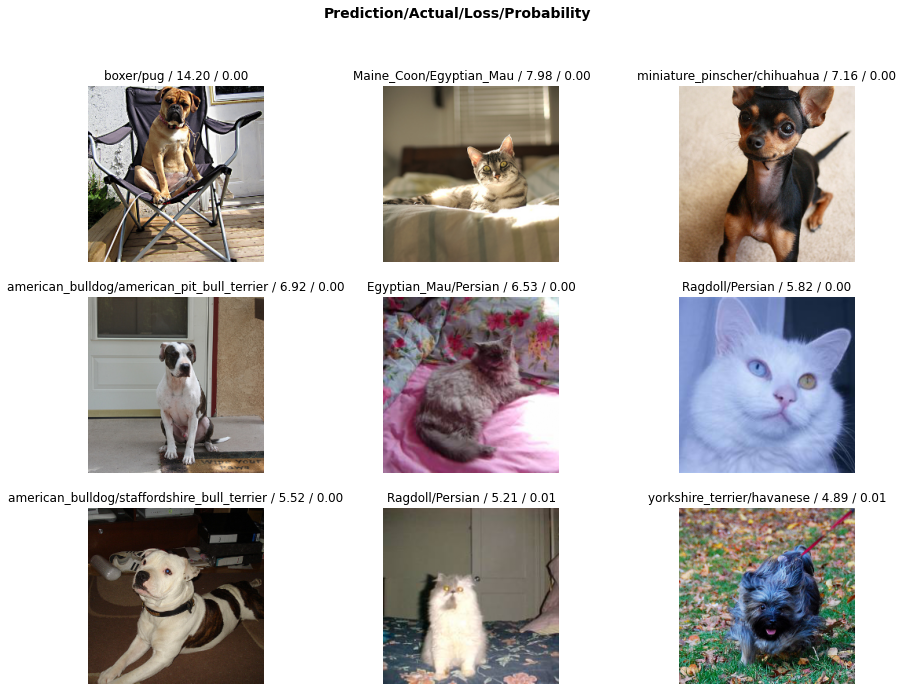

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))
# Question 6: 본 노트북에서 학습시키고 실행시키는 신경망은 주어진 인풋 이미지를 분류하는 
# 즉 인풋이미지에 대해서 37 개의 카테고리에 속할 확률을 계산해주는 신경망이다.
#  interp = ClassificationInterpretation.from_learner(learn)
# 는 이 분류 (Classification) 을 해석 (Interpretation) 하는데 사용할 object "interp" 를 생성한다.  



##(6.1) 37 개의 category가 무엇인지 적절한 명령을 실행하여 프린트하라. 
##[A] 바로위에 셀에 코딩해놨습니다. print(data.classes)



# (6.2) interp.plot_top_losses(9, figsize=(15,11)) 명령어가 하는 일이 무엇인지 대략 기술하라
##[A] 큰 손실함수 예측입니다. 예를들면 어떤 이미지를 강아지라고 매우 높은 확률로 인식했는데,
##    강아지가 아니라면 그만큼 손실도 커집니다. 이 명령어는 최고 손실을 표시함으로써, 머신러닝 과정에서 가장 잘못한것,
##    헷갈리는 데이터가 무엇인지 또 어느정도로 큰 확률로 잘못 예측되는지 알수 있습니다.



# (6.3) 아래 그림을 보면 디스플레이된 이미지 위에 두개의 이름과 2개의 값이 기술되어 있다. 이 기술은
# 아래에 디스플레이 되어 있는 이미지의 성격을 기술할 텐데, 각 기술이 해당 이미지에 대해서 말하는 바를 설명하라.
# 9개의 경우에 대해서 다 설명한다 
##[A] prediction/actual/loss/probability of actual class 로
##    퍼그를 박서이라 판단했고 손실은 14.20 이며 실제 예측확률은 0.005%미만으로 계산되었다.(여러번 트레이닝시 실제 맞게 판단한 횟수로 산정)
##    이집티안뮤를 메인쿤이라 판단했고 손실은 7.98이며 실제 예측확률은 0.005%미만으로 계산되었다.
##    치와와를 미니어쳐핀셔라 판단했고 손실은 7.16이며 실제 예측확률은 0.005%미만으로 계산되었다.
##    아메리칸핏불을 아메리칸불독이라 판단했고 손실은 6.92이며 실제 예측확률은 0.005%미만으로 계산되었다.
##    페르시안을 이집티안뮤라 판단했고 손실은 6.53이며 실제 예측확률은 0.005%미만으로 계산되었다.
##    페르시안을 란돌이라 판단했고 손실은 5.82이며 실제 예측확률은 0.005%미만으로 계산되었다.
##    불테리어를 아메리칸 불독이라 판단했고 손실은 5.2이며 실제 예측확률은 0.005%미만으로 계산되었다.
##    페르시안을 란돌이라 판단했고 손실은 5.21이며 실제 예측확률은 0.015%미만으로 계산되었다.
##    하바네스를 요크셔테리어라 판단했고 손실은 4.89이며 실제 예측확률은 0.015%미만으로 계산되었다.

Question 6 [10\10]

In [ ]:
doc(interp.plot_top_losses)

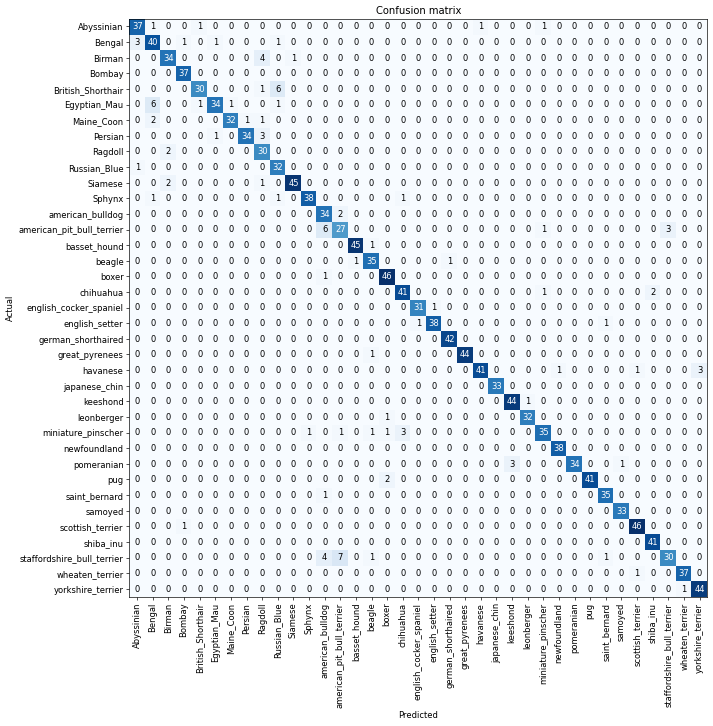

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)



# Question 7: 이 명령어는 아래 그림에 보는 것 처럼 confusion matrix 라는 것을 프린트하는데, 이 confusion matrix 는
# 본 신경망이 주어진 이미지를 37개의 카테코리로 얼마나 잘 분류하는지를 전체적으로 보여주는 표이다. 아래 표를 해석하여
# 할 줄 알아야 본 신경망을 제대로 사용한다고 할 수 있다. 


##아래 표를 해석하고 설명하라. 
##[A] 첫번째 행을 예로들면 아비니시안을 아비니시안으로 예측한 횟수가 37번 
##    비글로 오판한 경우가 1번 birman,bombay로 판다된 경우의 수는 없다는 뜻이다.
##    대각선을 제외한 나머지값은 전부 오판이므로 어떤 항목이 분류되는데 
##    오류가 많이 났는지 한눈에 알 수 있다.

Question 7 [10\10]

In [ ]:
interp.most_confused(min_val=2)
# Question 8: 이 문장은 8개의 값을 프린트하는데 이들 값이 어떤 종류의 값인지 설명하라.
#(재실행해서 항목이 좀 많아졌습니다.)

##[A] 위에서부터 가장 많이 오판한 순서이고 2번이상 오판된 경우 프린트된다.
##    위에서부터 
##    스탠퍼드 불테리어인데 아메리칸 핏불로 오판한 경우가 7번
##    British_Shorthair 인데 Russian_Blue로 오판한 경우 6번
##    Egyptian_Mau 인데 Bengal로 오판한 경우 6번
##    american_pit_bull_terrier 인데 american_bulldog로 오판한 경우 6번
##    Birman 인데 Ragdoll로 오판한 경우 4번
##    staffordshire_bull_terrier 인데 american_bulldog로 오판한 경우 4번
##    Bengal 인데 Abyssinian로 오판한 경우 3번
##    Persian 인데 Ragdoll로 오판한 경우 3번
##    american_pit_bull_terrier 인데 staffordshire_bull_terrier로 오판한 경우 3번
##    havanese 인데 yorkshire_terrier로 오판한 경우 3번
##    miniature_pinscher 인데 chihuahua로 오판한 경우 3번
##    pomeranian 인데 keeshond로 오판한 경우 3번
##    Maine_Coon 인데 Bengal로 오판한 경우 2번
##    Ragdoll 인데 Birman로 오판한 경우 2번
##    Siamese 인데 Birman로 오판한 경우 2번
##    american_bulldog 인데 american_pit_bull_terrier로 오판한 경우 2번
##    chihuahua 인데 shiba_inu'로 오판한 경우 2번
##    pug 인데 boxer로 오판한 경우 2번

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('British_Shorthair', 'Russian_Blue', 6),
 ('Egyptian_Mau', 'Bengal', 6),
 ('american_pit_bull_terrier', 'american_bulldog', 6),
 ('Birman', 'Ragdoll', 4),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('Bengal', 'Abyssinian', 3),
 ('Persian', 'Ragdoll', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('havanese', 'yorkshire_terrier', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('pomeranian', 'keeshond', 3),
 ('Maine_Coon', 'Bengal', 2),
 ('Ragdoll', 'Birman', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('chihuahua', 'shiba_inu', 2),
 ('pug', 'boxer', 2)]

Question [5\5]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)



# Question 9: 윗 문장들은 신경망을 수정가능한 모드로 바꾸고 (unfreeze) 다시 학습을 시켰는데, 도대체 무엇을 어떻게 
# 학습시켰는가?
##[A] 이는 앞에 4번의 epoch로 학습한뒤 한번더 레이어를 쌓아 학습하는 것이 아닌
##    맨처음으로 돌아가 전부 바꿔버리며 학습하는 것이기 때문에 오류가 더 커진다.



epoch,train_loss,valid_loss,error_rate,time
0,0.671680,0.423844,0.125169,01:23


Question 9 [9\10]

In [ ]:
learn.load('stage-1');

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


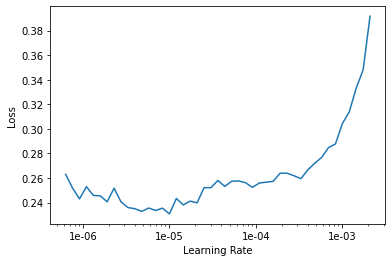

In [ ]:
learn.recorder.plot()


# Question 10: 학습 레이트 (lr = learning rate) 가 가로축에 나타나고 loss 가 세로축에 나타난 그래프이다. 


#(10.1) 여기서 learning rate 라는 것이 무엇인지 설명하라. 
##[A] 학습률이라고 하며 한번 학습할때 얼마만큼 학습해야하는지 학습양을 의미하고,
##    매 학습시마다 가중치 매개변수가 갱신된다.



#(10.2) loss 가 무엇인지 설명하라. 
##[A] 손실이다. 학습의 결과가 어느정도 인지 판단할 수 있는 척도이다.
##    위 그래프에서는 매개변수에 대한 손실함수를 표한 해줄수있다.



#(10.3) 다음 그래프는 무엇을 말하고 있는가?
##[A]  학습률을 높이면 로스가 점점 커져서 오버피팅이 된다는것을 말하고 있다.
##     따라서 최적의 학습률은 약 1e-5근방으로 추정된다.



Question [10\10]

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
# Question 11: 

##(11.1) 윗 문장을 learning rate 를 수정했는데, 이것의 의미는 무엇인가? 
##[A] slice는 시작값과 중지값을 취할수 있다 즉 위 코드의 의미는
##1e-6의 학습률로 첫번째 레이러를 훈련하고
##1e-4의 학습률로 가장 마지막 레이어를 훈련하는 것입니다. 
##(첫번째와 마지막을 제외한 레이어는 1e-6~1e-4사이를 동일한 간격으로)



##(11.2) 러닝 레이트를 수정한 결과 무엇이 바뀌었는가?
##[A] 로스가 줄어들고 학습 결과가 이전보다 훨씨 좋다졌다. 


epoch,train_loss,valid_loss,error_rate,time
0,0.258658,0.222485,0.071719,01:26
1,0.227746,0.217614,0.068336,01:23


Question 11 [5\5]

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


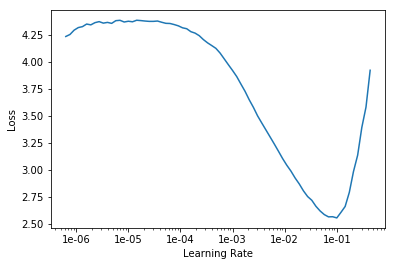

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

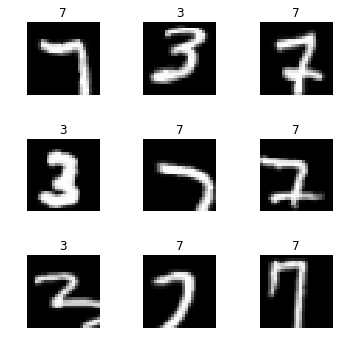

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

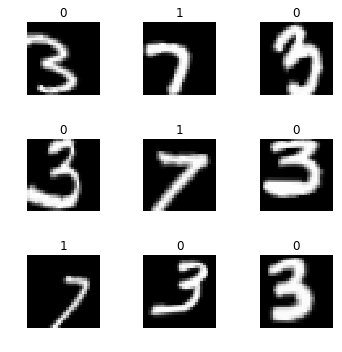

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']